# Dectection Analysis 

I believe the detection metrics are sufficient upon visual inspection. There is reason to believe the poorer metrics are associated to cars coming from the top right of the image where the cars are furthest away from the camera. This causes them to be smaller spanning only fewer pixels across. The data annotations for cars in this region proved to be difficult, annotations were not always obvious and was at times just a judgement call. 

By creating a y_lim threshold predicted y_centers beyond this threshold will not be evaluated when generating the metrics. My hope is this metrics by only considering cars that are of reasonable distance will prove to be much better avoiding issues of poor annotation. 

To meet the goals above the following custom metrics will be developed:
- Calculating metrics seperated by discrete bins catergorized by bounding box area
- y_lim threshold to avoid detection on cars that are too far from the camera

## Packages

In [ ]:
import numpy as np 
import os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
import cv2

## Constants

In [47]:
SEED=53456

# setting up the paths
cwd=os.getcwd()
root = os.path.dirname(cwd)
dataset_path = os.path.join(root, 'dat','annotate','yolo_data')
val_image_dir = os.path.join(dataset_path, 'images','val')
val_image_paths = [os.path.join(val_image_dir, file) for file in os.listdir(val_image_dir)]
label_path = os.path.join(dataset_path, 'labels','train')
label_path = os.path.join(dataset_path, 'labels','val')
run_dir = os.path.join(root, 'runs','detect')
best_weights_path  = os.path.join(run_dir, 'train14', 'weights','best.pt')

## Functions

In [48]:
def plot_boxes(img_num, results, df):
    res = results[img_num]
    image_rgb = cv2.cvtColor(res.orig_img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)

    for box in res.boxes.xywh:
        x_center, y_center, width, height = box
        rect = plt.Rectangle((x_center - width / 2, y_center - height / 2), width, height, fill=False, color='red')
        plt.gca().add_patch(rect)
    img_h, img_w, channels = res.orig_img.shape


    #plot truth boxes from df
    boxes = df[df['img_num']==img_num]
    for i, box in boxes.iterrows():
        box[['x_center', 'width']] *= img_w
        box[['y_center', 'height']] *= img_h
        x_center, y_center, width, height = box['x_center'], box['y_center'], box['width'], box['height']
        rect = plt.Rectangle((x_center - width / 2, y_center - height / 2), width, height, fill=False, color='green')
        plt.gca().add_patch(rect)
    plt.show()

## Loading train labels

In [29]:
train_labels = os.listdir(label_path)

label_array = []
for i, label in enumerate(train_labels):
    array = np.loadtxt(os.path.join(label_path, label), delimiter=' ', dtype=float)
    img_num  = np.repeat(i, array.shape[0]).reshape(-1,1)
    array = np.hstack([array, img_num])
    label_array.append(array)
label_array = np.vstack(label_array)

df = pd.DataFrame(label_array, columns=['class', 'x_center', 'y_center', 'width', 'height', 'img_num'])
df['area']  = df['width'] * df['height']

## Box area vs y_center

There is a general clear trend that closer to the top of the image (lower the y_center) the smaller the area of the bounding box. This makes sense because cars further away are typically smaller than cars that are closer. 

Now when taking a look at the loss metrics is should be categorized by size. If the performance for the larger bounding boxes are significantly higher we can than try to impose a limitation on the y_center that we will predict on and only produce predictions there. 

So my next steps would be to produce the metrics on validation data for several y_limits while also looking at the metrics across different sizes. 

Now I can also improve performance by training for longer or tuning the confidence scores. 

<Axes: xlabel='y_center', ylabel='area'>

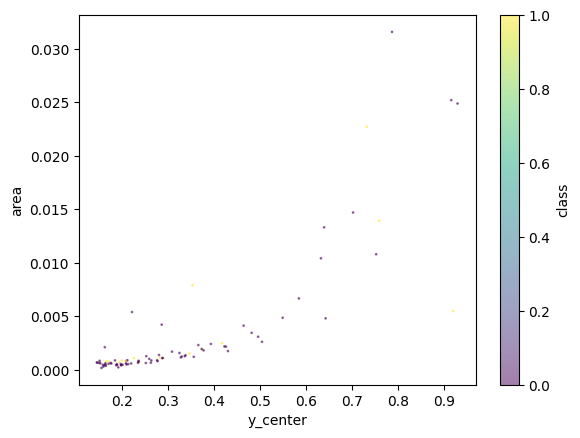

In [5]:
df.plot.scatter(x='y_center', y='area', c='class', colormap='viridis', s=1, alpha=0.5)

(0.0, 0.02)

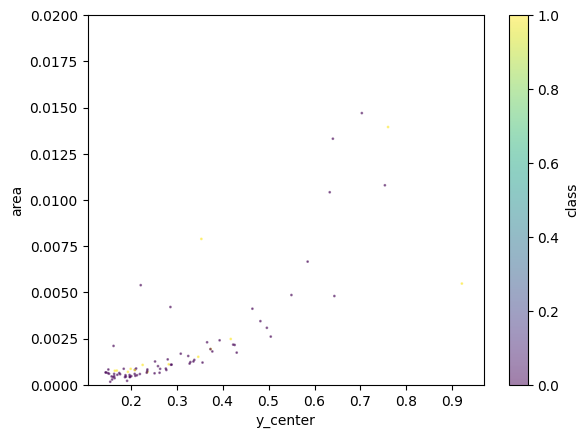

In [7]:
df.plot.scatter(x='y_center', y='area', c='class', colormap='viridis', s=1, alpha=0.5)
plt.ylim(0, 0.02)

## Validation prediction 

In [ ]:
model = YOLO(best_weights_path)
results = model.predict(source=val_image_paths , save_json=True)

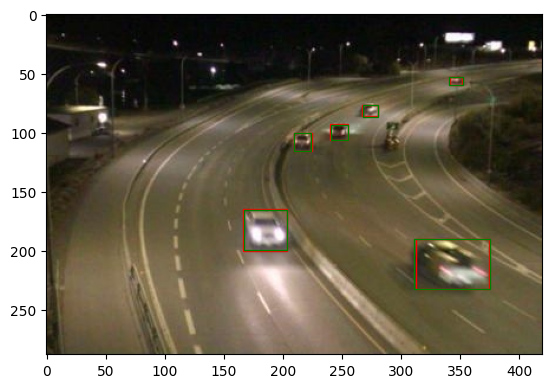

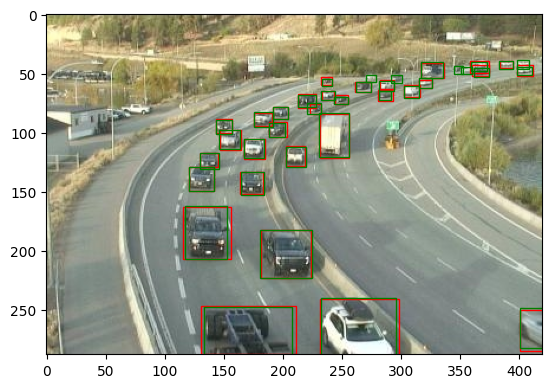

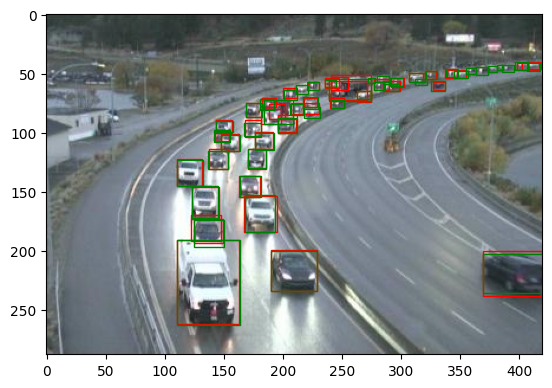

In [45]:
for i in range(3):
    plot_boxes(i, results, df)